In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from itertools import chain, product
%matplotlib inline

# Question 2 - Camera calibration

## Section A - hw1 based calibration

In [ ]:
image_name = "ICBV231-1-chess{}.jpeg"
images = [cv2.imread(image_name.format(i), cv2.IMREAD_GRAYSCALE) for i in range (0,20)]
# The pattern size is the number of inner corenrs in the chessboard (corners per row, corners per column).
pattern_size=(4,7)
corners = [cv2.findChessboardCorners(image, pattern_size) for image in images]

image_corners = [cv2.drawChessboardCorners(cv2.cvtColor(images[i], cv2.COLOR_GRAY2RGB),
                                           pattern_size, 
                                           corners[i][1], 
                                           corners[i][0]) 
                 for i in range(20)]

xs, ys = pattern_size

world_points = np.array([(x, y, 0)
                         for y, x in product(range(ys), range(xs))],
                        dtype=np.float32)

# perform calibration here
retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objectPoints=[world_points for i in range(20)], 
                                                                     imagePoints=[corner[1] for corner in corners], 
                                                                     imageSize=images[0].shape[::-1],  
                                                                     cameraMatrix=None, 
                                                                     distCoeffs=None)

extrinsic_transformations = [np.concatenate([cv2.Rodrigues(rvec)[0], tvec], axis=1)
                             for tvec, rvec in zip(tvecs, rvecs)]

M_matrices = [np.dot(cameraMatrix, x)
              for x in extrinsic_transformations]


## Section B - 3d modeling the resources

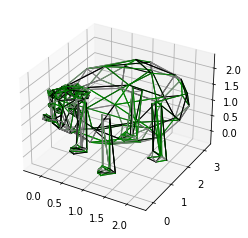

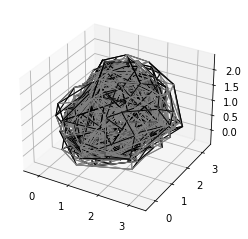

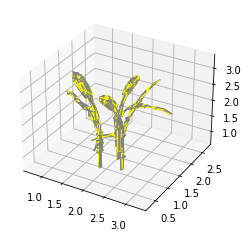

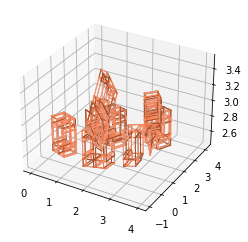

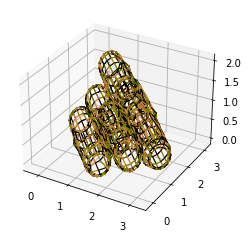

In [ ]:
import re
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
import math
import random
from matplotlib.pyplot import imshow, figure

filename_Sheep = "ICBV231-1-Sheep.obj"
filename_Rock = "ICBV231-1-Rock.obj"
filename_Wheat = "ICBV231-1-Wheat.obj"
filename_Mortar = "ICBV231-1-Blocks.obj"
filename_Tree = "ICBV231-1-Wood.obj"

resources_files = {"Sheep": filename_Sheep, "Rock": filename_Rock, "Wheat": filename_Wheat, "Mortar": filename_Mortar, "Tree": filename_Tree}
pi = math.pi
jindex = 6

 
def scale_and_center_for_looks(vertices ,file_name):
    min_x, min_y, min_z = np.min(vertices, axis=0)
    max_x, max_y, max_z = np.max(vertices, axis=0)
    scale_factor = 3
    add_x = 1.5
    add_y = 2
    add_z = 3
    scale_x = 1
    scale_y = 1
    scale_z = 1
    if(file_name == 'Wheat'):
      add_x = 2
      add_y = 1.5
      add_z = 2
      scale_z = 2.2
      scale_y = 0.6
      scale_factor = 6

    if(file_name == 'Mortar'):
      add_y = 1.6
      add_x = 2
      scale_y = 0.7
      scale_x = 1
      scale_factor = 4

    if(file_name == 'Sheep'):
      add_x = 1
      add_y = 1.5
      add_z = 1
      scale_factor = 3
      scale_y = 0.9
      scale_z = 0.9
    if(file_name == 'Rock'):
      add_x = 1.5
      add_y = 1.5
      add_z = 1
      scale_factor = 4
      scale_z = 1.4

    if(file_name == 'Tree'):
      add_y = 1.5
      add_x = 1.5
      add_z = 1
      scale_factor = 3.5
      
    scale = scale_factor / max(max_x - min_x, max_y - min_y, max_z - min_z)
    center_x = (min_x + max_x) / 2
    center_y = (min_y + max_y) / 2
    center_z = (min_z + max_z) / 2
    
    scaled_vertices = []
    for v in vertices:
        x = (v[0] - center_x) * scale/scale_x + add_x
        y = (v[1] - center_y) * scale/scale_y + add_y
        z = (v[2] - center_z) * scale/scale_z + add_z
        scaled_vertices.append((x, y, z))
    return scaled_vertices

def scale_and_center(vertices ,file_name):
    min_x, min_y, min_z = np.min(vertices, axis=0)
    max_x, max_y, max_z = np.max(vertices, axis=0)
    scale_factor = 3
    add_x = 1.5
    add_y = 2
    add_z = 3
    scale_x = 1
    scale_y = 1
    scale_z = 1
    if(file_name == 'Wheat'):
      add_x = 1.5
      add_y = 1.5
      add_z = 0.75
      scale_x = 1.7
      scale_y = 0.8
      scale_z = 0.8
      scale_factor = 6
    if(file_name == 'Mortar'):
      add_x = 1
      add_y = 1.6
      scale_x = 1
      scale_y = 1.2
      scale_z = 1.2
      add_z = 1.5
      scale_factor = 4
    if(file_name == 'Sheep'):
      add_x = 1
      add_y = 1.5
      add_z = 1
      scale_factor = 3
      scale_y = 0.9
      scale_z = 0.9
    if(file_name == 'Rock'):
      add_x = 1.5
      add_y = 1.5
      add_z = 1
      scale_x = 1.2
      scale_z = 1.4
      scale_factor = 4
    if(file_name == 'Tree'):
      add_y = 1.5
      add_x = 1.5
      add_z = 1
      scale_factor = 3.5
    scale = scale_factor / max(max_x - min_x, max_y - min_y, max_z - min_z)
    center_x = (min_x + max_x) / 2
    center_y = (min_y + max_y) / 2
    center_z = (min_z + max_z) / 2
    
    scaled_vertices = []
    for v in vertices:
        x = (v[0] - center_x) * scale/scale_x + add_x
        y = (v[1] - center_y) * scale/scale_y + add_y
        z = (v[2] - center_z) * scale/scale_z + add_z
        scaled_vertices.append((x, y, z))
    return scaled_vertices

def extract_vertices_and_edges(file_path):
    vertices = []
    faces = []
    edges = []
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith("v "):
                vertex = line.split(" ")
                vertex = [float(x) for x in vertex[1:]]
                vertices.append(vertex)
            elif line.startswith("f "):
                face = line.split(" ")
                face = [int(x.split("/")[0]) for x in face[1:]]
                faces.append(face)
    for face in faces:
        for i in range(len(face)):
            edge = (face[i], face[(i+1)%len(face)])
            edges.append(edge)
    return edges, vertices

def rotate_x(vertices, angle):
    rotation_matrix = np.array([[1, 0, 0],
                                [0, np.cos(angle), -np.sin(angle)],
                                [0, np.sin(angle), np.cos(angle)]])
    return np.dot(vertices, rotation_matrix)

def rotate_y(vertices, angle):
    rotation_matrix = np.array([[np.cos(angle), 0, np.sin(angle)],
                                [0, 1, 0],
                                [-np.sin(angle), 0, np.cos(angle)]])
    return np.dot(vertices, rotation_matrix)

def rotate_z(vertices, angle):
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle), 0],
                                [np.sin(angle), np.cos(angle), 0],
                                [0, 0, 1]])
    return np.dot(vertices, rotation_matrix)

def rotate_for_looks(Vertices,file_name):
  if(file_name == 'Sheep'):
    Vertices  = rotate_x(Vertices, -pi/2)
    Vertices  = rotate_z(Vertices,pi/1.5)
  if(file_name == 'Rock'):
    Vertices = rotate_x(Vertices,-pi/2)
    Vertices = rotate_z(Vertices,pi/1.5)
  if(file_name == 'Tree'):
    Vertices = rotate_x(Vertices,-pi/2)
    Vertices = rotate_z(Vertices,-pi/4)
  if(file_name == 'Mortar'):
    Vertices = rotate_x(Vertices,-pi/1.9)
    Vertices = rotate_z(Vertices,pi/1.5) 
    # Vertices = rotate_y(Vertices,pi/1.5)
  return Vertices

def rotate(Vertices,file_name):
  if(file_name == 'Tree'):
    Vertices = rotate_x(Vertices,-pi/2)
    Vertices = rotate_z(Vertices,-pi/4)
  if(file_name == 'Mortar'):
    Vertices = rotate_x(Vertices,-pi/2)
    Vertices = rotate_z(Vertices,pi/1.5) 
    Vertices = rotate_y(Vertices,pi/1.5)
  if(file_name == 'Rock'):
    Vertices = rotate_x(Vertices,-pi/2)
    Vertices = rotate_z(Vertices,pi/1.5) 
    Vertices = rotate_y(Vertices,pi/1.5)   
  if(file_name == 'Sheep'):
    Vertices  = rotate_y(Vertices, pi/2)
    Vertices = rotate_x(Vertices,-pi)
    Vertices = rotate_z(Vertices,-pi/1.1)
    Vertices = rotate_x(Vertices,pi/2) 
  if(file_name == 'Wheat'):
    Vertices  = rotate_y(Vertices, pi/2)
    Vertices = rotate_x(Vertices,-pi/2)
    Vertices = rotate_z(Vertices,-pi)
  return Vertices


resources = {}
resources_for_looks = {}
for file_name, filename in resources_files.items():
  Edges, Vertices = extract_vertices_and_edges(filename)
  resources[file_name] = (Vertices, Edges)
  Rotated_vertices = rotate(Vertices, file_name) 
  Scale_Vertices = scale_and_center(Rotated_vertices, file_name)
  #for_looks
  Rotated_vertices2 = rotate_for_looks(Vertices, file_name) 
  Scale_Vertices2 = scale_and_center_for_looks(Rotated_vertices2, file_name)
  
  resources[file_name] = (Scale_Vertices, Edges)
  resources_for_looks[file_name] = (Scale_Vertices2, Edges)


def plot_edges(file_name, resource):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    vertices, edges = resource[0],resource[1]
    color1 = 'black'
    color2 = 'brown'
    color3 = 'yellow'
    if(file_name == 'Tree'):
      color1= 'olive'
      color2='black'
      color3='peru'
    if(file_name == 'Sheep'):
      color1= 'black'
      color2='green'
      color3='grey'
    if(file_name == 'Mortar'):
      color1='coral'
      color2='darksalmon'
      color3='sienna'
    if(file_name == 'Wheat'):
      color1= 'yellow'
      color2='grey'
      color3='grey'
    if(file_name == 'Rock'):
      color1='black'
      color2='grey'
      color3='grey'

    for edge in edges:
        if edge[0]-1 < len(vertices) - 1 and edge[1]-1 < len(vertices) - 1:
          x = [vertices[edge[0]-1][0], vertices[edge[1]-1][0]]
          y = [vertices[edge[0]-1][1], vertices[edge[1]-1][1]]
          z = [vertices[edge[0]-1][2], vertices[edge[1]-1][2]]
          random_float = random.random()
          if random_float < 0.3:
            ax.plot(x, y, z, linewidth=1,color = color1)
          elif 0.3 < random_float < 0.7:
            ax.plot(x, y, z, linewidth=1,color = color2)
          else:
            ax.plot(x, y, z, linewidth=1,color = color3)
    plt.show()

# plot
for file_name, resource in resources_for_looks.items():
    plot_edges(file_name, resource)


## Section B2 - outsourcing the cameraMatrice and the resources vertices and edges

In [ ]:
# optional

# with open('ICBV231-1-resources.txt', 'w') as file:
#    for file_name, resource in resources.items():
#     file.write(f"{file_name}:{','.join(f'({v[0]},{v[1]},{v[2]})' for v in resource[0])}:{','.join(f'({e[0]},{e[1]})' for e in resource[1])}\n")

# np.savetxt('ICBV231-1-Matrice.txt', M_matrices[jindex], delimiter=",")

## Section C - plotting the result on the katan board

image6 lines for cube


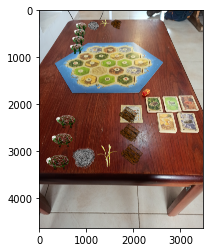

In [ ]:
jindex = 6

image_to_show = cv2.imread('ICBV231-1-katan_image.jpeg')
image_to_show = cv2.cvtColor(image_to_show, cv2.COLOR_BGR2RGB)

def move_vertices(vertices, distance_x, distance_y):
    # print(vertices)
    vertices2 = []
    # Loop over all vertices and move them to the new position with padding
    for i in range(len(vertices)):
        x = distance_x + vertices[i][0]
        y = distance_y + vertices[i][1]
        z = vertices[i][2]
        vertices2.append((x, y, z))
    return vertices2
  
image_with_cube = image_to_show
imshow(image_to_show)
pad=-7.5
pad_y = -23

players = {}

def color_and_rand(file_name):
    color1=(255, 179, 102)
    color2=(0, 0, 0)
    color3=(0, 0, 0)
    rand_val1 = 0.7
    rand_val2 = 0.7
    rand_val3 = 0.7 
    if(file_name == 'Tree'):
      color1 = (102, 51, 0)
      color2= (0, 0, 0)
      color3=(0, 0, 0)
      rand_val1 = 0.6
    if(file_name == 'Sheep'):
      color1 = (1, 1, 1)
      color2 = (0, 102, 0)
      color3= (160, 160, 160)
      rand_val1 = 0.9
    if(file_name == 'Mortar'):
      color1=(255, 179, 102)
      color2=(0, 0, 0)
      color3=(0, 0, 0)
      rand_val1 = 0.9
    if(file_name == 'Wheat'):
      color1 = (204, 204, 0)
      color2= (224, 224, 224)
      color3=(0, 0, 0)
      rand_val1 = 0.5
    if(file_name == 'Rock'):
      color1 = (160, 160, 160)
      color2= (0, 0, 0)
      color3=(0, 0, 0)
      rand_val1 = 0.7
    return color1, color2, color3, rand_val1, rand_val2, rand_val3

def plot_world_points(file_name, resource, pad):
    vertices2 = resource[0]
    edges = resource[1]
    thickness = 2
    rand_val1 = 0.7
    rand_val2 = 0.7
    rand_val3 = 0.7
    image_with_cube = image_to_show

    color1, color2, color3, rand_val1, rand_val2, rand_val3 = color_and_rand(file_name)

    vertices = move_vertices(vertices2, pad_y, pad)
    homogeneous_points = [M_matrices[jindex]@np.transpose(np.concatenate(([vertice], [[1]]), axis=1)) for vertice in vertices]
    xy_projection_dot = [homogeneous_point[0:2,:]/homogeneous_point[2, 0] for homogeneous_point in homogeneous_points]

    if(file_name == 'Mortar' or file_name == 'Wheat' or file_name == 'Rock' or file_name == 'Tree'):
      for edge in edges:
        if edge[0]-1 < len(xy_projection_dot) - 1 and edge[1]-1 < len(xy_projection_dot) - 1:
          x = [xy_projection_dot[edge[0]-1][0], xy_projection_dot[edge[1]-1][0]]
          y = [xy_projection_dot[edge[0]-1][1], xy_projection_dot[edge[1]-1][1]]
          random_float = random.random()
          if random_float < rand_val1:
            image_with_cube = cv2.line(image_with_cube, (int(x[0]),int(y[0])),  (int(x[1]),int(y[1])), color1, thickness)
          else:
            image_with_cube = cv2.line(image_with_cube, (int(x[0]),int(y[0])),  (int(x[1]),int(y[1])), color2, thickness)
    if(file_name == 'Sheep'):
      for edge in edges:
        if edge[0]-1 < len(xy_projection_dot) - 1 and edge[1]-1 < len(xy_projection_dot) - 1:
          x = [xy_projection_dot[edge[0]-1][0], xy_projection_dot[edge[1]-1][0]]
          y = [xy_projection_dot[edge[0]-1][1], xy_projection_dot[edge[1]-1][1]]
          z = [vertices[edge[0]-1][2], vertices[edge[1]-1][2]]
          x2 = [vertices[edge[0]-1][0], vertices[edge[1]-1][0]]
          random_float = random.random()
          if z[0] > 1.5:
            image_with_cube = cv2.line(image_with_cube, (int(x[0]),int(y[0])),  (int(x[1]),int(y[1])), color1, thickness)
          elif z[0] < 0.5:
            image_with_cube = cv2.line(image_with_cube, (int(x[0]),int(y[0])),  (int(x[1]),int(y[1])), (250,250,250), thickness)
          elif random_float < rand_val1:
            image_with_cube = cv2.line(image_with_cube, (int(x[0]),int(y[0])),  (int(x[1]),int(y[1])), color2, thickness)
          else:
            image_with_cube = cv2.line(image_with_cube, (int(x[0]),int(y[0])),  (int(x[1]),int(y[1])), color3, thickness)

# player 1:
Sheep_num1=3
Rock_num1=1
Wheat_num1=1
Mortar_num1=0
Tree_num1=3
player1 = {'Sheep':Sheep_num1,'Rock':Rock_num1,'Wheat':Wheat_num1,'Mortar':Mortar_num1,'Tree':Tree_num1}
# player 2:
Sheep_num2=4
Rock_num2=1
Wheat_num2=1
Mortar_num2=0
Tree_num2=1
player2 = {'Sheep':Sheep_num2,'Rock':Rock_num2,'Wheat':Wheat_num2,'Mortar':Mortar_num2,'Tree':Tree_num2}
players = [player1,player2]

for i in range(len(players)):
  if i == 1:
    pad=-8
    pad_y = 24
  if i == 0:
    pad=-7
    pad_y = -23
  for file_name, resource in resources.items():
    for key, value in players[i].items():
      if i == 1:
        pad_y = 24
      if i == 0:
        pad_y = -23
      if(key == file_name):
        for x in range(players[i][key]):
          plot_world_points(file_name, resource, pad)
          if i == 1:
            pad_y -= 4.5
          if i == 0:
            pad_y += 4
          if x == players[i][key]-1:
            pad += 3.8
    
print("image" + str(jindex) + " lines for cube")
imshow(image_to_show)
plt.show()